<a href="https://colab.research.google.com/github/Jed-77/tensorflow-deeplearning/blob/master/TF2_0_LSTM_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[0 1 2 3 4 5 6 7 8 9]


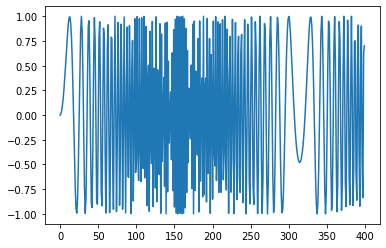

In [0]:
# Make the original data and plot
series = np.sin((0.1*np.arange(400))**2)
plt.plot(series)

In [0]:
# Build the Dataset

# - Lets see if we can use T past value to predict the next value (T=10)
# - We are only considering one value/feature (D=1)
# - We then create X which contains all windows of length 10 from the sequence
# - And Y which is all of the next values after window (11, 12... up to 400)
T= 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]  #K=1
  Y.append(y)

# Reshape X, Y so they are compatible with tensorflow
X = np.array(X).reshape(-1, T, D)  # make it N x T x D
Y = np.array(Y)
print("X.Shape: ", X.shape, "Y.Shape: ", Y.shape)

# The number of windows we have is N
N = len(X)
print(N)



X.Shape:  (390, 10, 1) Y.Shape:  (390,)
390


In [0]:
# Autoregressive Linear Model
# Build
K = 1
i = Input(shape=(T, D))
x = Dense(K)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.01),)
# Train
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

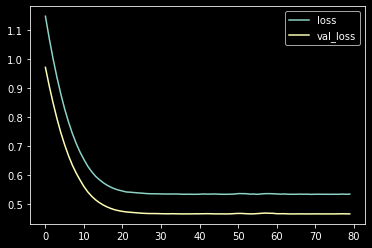

In [0]:
# Plot our loss per iteration.
from matplotlib import style
style.use('dark_background')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

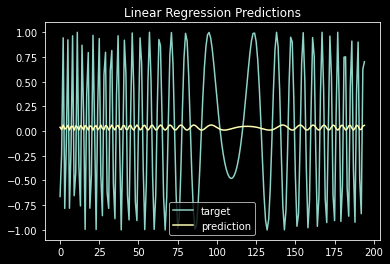

In [0]:
# Forecase One Time Step
validation_target = Y[-N//2:]
validation_predictions = []

# last train input (last window of 10)
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # make the prediction using the x
  i += 1
  validation_predictions.append(p) # update the prediction

# plot the output
plt.plot(validation_target, label='target')
plt.plot(validation_predictions, label='prediction')
plt.title('Linear Regression Predictions')
plt.legend()

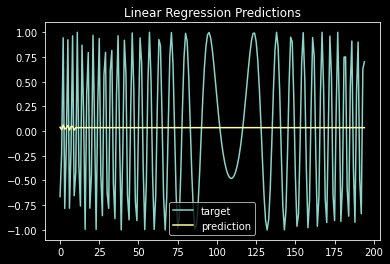

In [0]:
# Forecast Multi-Time Step
validation_target = Y[-N//2:]
validation_predictions = []

# last train input (last window of 10)
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # make the prediction using the x
  validation_predictions.append(p) # update the prediction
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# plot the output
plt.plot(validation_target, label='target')
plt.plot(validation_predictions, label='prediction')
plt.title('Linear Regression Predictions')
plt.legend()

In [0]:
# RNN (LSTM) Model
X = X.reshape(-1, T, 1) # make it N x T x D

# RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer=Adam(lr=0.05),
)

# Train
r = model.fit(
    X[:N//2], Y[:N//2],
    batch_size=32,
    epochs=200,
    validation_data = (X[-N//2:], Y[-N//2:]),
)

Epoch 1/200
7/7 [==============================] - 0s 57ms/step - loss: 0.5686 - val_loss: 0.5295
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 0.5102 - val_loss: 0.4911
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 0.5079 - val_loss: 0.4851
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 0.4747 - val_loss: 0.4514
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 0.4400 - val_loss: 0.4910
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 0.3344 - val_loss: 0.4397
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 0.2534 - val_loss: 0.3251
Epoch 8/200
7/7 [==============================] - 0s 9ms/step - loss: 0.1458 - val_loss: 0.2171
Epoch 9/200
7/7 [==============================] - 0s 9ms/step - loss: 0.1051 - val_loss: 0.1764
Epoch 10/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0821 - val_loss: 0.1247
Epoch 11/200
7/7 [=====

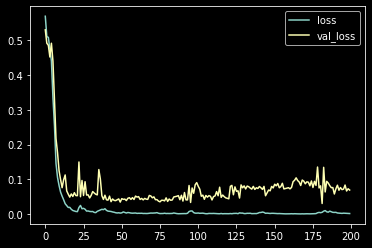

In [0]:
# Plot our loss per iteration.
from matplotlib import style
style.use('dark_background')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [0]:
# Summary of our RNN
model.summary()

# So we can get weights and biases
Wx, Wh, bh = model.layers[1].get_weights()
print(Wx.shape, Wh.shape, bh.shape)
Wo, bo = model.layers[2].get_weights()
print(Wo.shape, bo.shape)

(390, 1)


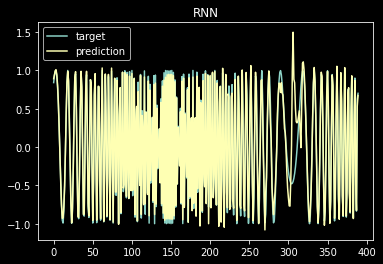

In [0]:
# One Step Forecast (not truly correct as we are using all information available)
# Multi step is better becuase we are using estimates to calculate estimates
# Recursion!
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

# plot the output
plt.plot(Y, label='target')
plt.plot(predictions, label='prediction')
plt.title('RNN')
plt.legend()


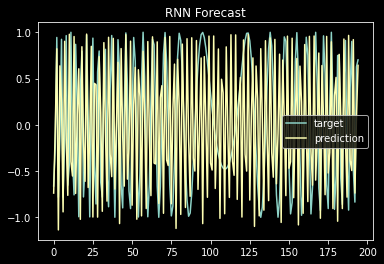

In [0]:
# Multi-Step Forecast
target = Y[-N//2:]  # test data
input_ = X[-N//2]   # test data
forecast = []

while len(forecast) < len(target):
  p = model.predict(input_.reshape(1, T, -1))[0,0] # make the prediction using the x
  forecast.append(p) # update the prediction
  input_ = np.roll(input_, -1)  # move the window along
  input_[-1] = p # and the end value is the prediction from the last!!!

# plot the output
plt.plot(target, label='target')
plt.plot(forecast, label='prediction')
plt.title('RNN Forecast')
plt.legend()